In [46]:
import scanpy as sc
from matplotlib import pyplot as plt
import os

In [7]:
import scvi

In [8]:
adata_filtered = sc.read("/home/jovyan/ifbdata/spatial_cell_id/Kush/Scanpy_analysis/New_analysis/adata_filtered_scvi.h5ad")

In [22]:
adata_filtered.layers["counts"] = adata_filtered.X.copy()  # preserve counts

In [10]:
sc.pp.normalize_total(adata_filtered, target_sum=1e4)
sc.pp.log1p(adata_filtered)

adata_filtered.raw = adata_filtered  # freeze the state in `.raw`

In [14]:
sc.pp.highly_variable_genes(
    adata_filtered,
    n_top_genes=3000,
    subset=True,
    #layer="counts",
    batch_key="Dataset",
)

In [15]:
scvi.model.SCVI.setup_anndata(
    adata_filtered,
    layer="counts",
    categorical_covariate_keys=["Dataset"],
    continuous_covariate_keys=['pct_counts_mt', 'pct_counts_ribo'],
)

/opt/conda/lib/python3.12/site-packages/scvi/data/fields/_base_field.py:63: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)


In [16]:
model = scvi.model.SCVI(adata_filtered)

In [17]:
model

SCVI model with the following parameters: 
n_hidden: 128, n_latent: 10, n_layers: 1, dropout_rate: 0.1, dispersion: gene, gene_likelihood: zinb, 
latent_distribution: normal.
Training status: Not Trained
Model's adata is minified?: False

In [19]:
scvi.settings.dl_kwargs = {"num_workers": 8} # Use more core
model.train() # Forza CPU

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/conda/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=63` in the `DataLoader` to improve performance.


Training:   0%|          | 0/12 [00:00<?, ?it/s]

/opt/conda/lib/python3.12/site-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/opt/conda/lib/python3.12/site-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/opt/conda/lib/python3.12/site-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/opt/conda/lib/python3.12/site-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/opt/conda/lib/python3.12/site-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the 

In [23]:
adata_filtered.layers["counts"] 

<Compressed Sparse Row sparse matrix of dtype 'float32'
	with 125085761 stored elements and shape (693294, 3000)>

In [27]:
adata_filtered.obs["summary"] = adata_filtered.layers['counts'].sum(axis=1)  # Sum of counts per cell
print(adata_filtered.obs["summary"].describe())  # Check if values are around 10,000

count    693294.000000
mean        360.216888
std         121.109085
min          24.507574
25%         262.720673
50%         344.043350
75%         446.982468
max         949.320679
Name: summary, dtype: float64


In [28]:
latent = model.get_latent_representation()

In [29]:
adata_filtered.obsm["X_scVI"] = latent

In [30]:
adata_filtered.layers["scvi_normalized"] = model.get_normalized_expression(library_size=10e4)

In [31]:
adata_filtered.obsm["X_scVI"]

array([[ 0.28530788, -1.093288  , -0.4590187 , ...,  0.57797015,
        -0.4492014 ,  0.39635587],
       [-0.5120884 ,  0.76199466, -0.4567548 , ...,  0.08584511,
         0.5149786 ,  0.38697398],
       [-0.47144088, -0.21216917,  0.19197017, ...,  0.32921362,
         0.6076449 ,  0.41701436],
       ...,
       [-0.22150782,  2.0818176 ,  1.389831  , ...,  0.3473205 ,
         0.16377915,  0.5370226 ],
       [ 0.151052  ,  1.5405159 , -1.0978379 , ...,  0.24775577,
         0.4599442 ,  0.54052496],
       [ 1.1016864 ,  1.1974263 ,  0.6137692 , ...,  1.8795911 ,
        -0.05206998, -0.75793326]], dtype=float32)

In [36]:
sc.tl.pca(adata_filtered.layers['scvi_normalized'])

array([[-4132.303   ,   197.5927  ,   315.78656 , ...,   -55.921043,
           64.82304 ,   -94.19448 ],
       [-3860.6707  ,   358.4074  ,  1110.882   , ...,    22.544981,
          -86.36303 ,    22.438135],
       [-3727.6838  ,   115.147575,  -948.13855 , ...,   -81.80005 ,
           40.059658,    50.848297],
       ...,
       [-4217.7344  ,   712.37946 ,  1274.8397  , ...,   448.903   ,
         -190.82097 ,    74.71853 ],
       [-1325.9637  ,  2027.1663  ,  2995.32    , ...,    91.49317 ,
         -164.51398 ,   337.38416 ],
       [-4267.1016  ,   578.6082  ,  3572.8032  , ...,  -505.20807 ,
         -393.49393 ,   358.89975 ]], dtype=float32)

In [38]:
sc.pp.neighbors(adata_filtered, n_pcs=30, n_neighbors=20)
sc.tl.umap(adata_filtered, min_dist=0.3)

In [33]:
sc.tl.pca(adata_filtered)
sc.pp.neighbors(adata_filtered, n_pcs=30, n_neighbors=20)
sc.tl.umap(adata_filtered, min_dist=0.3)

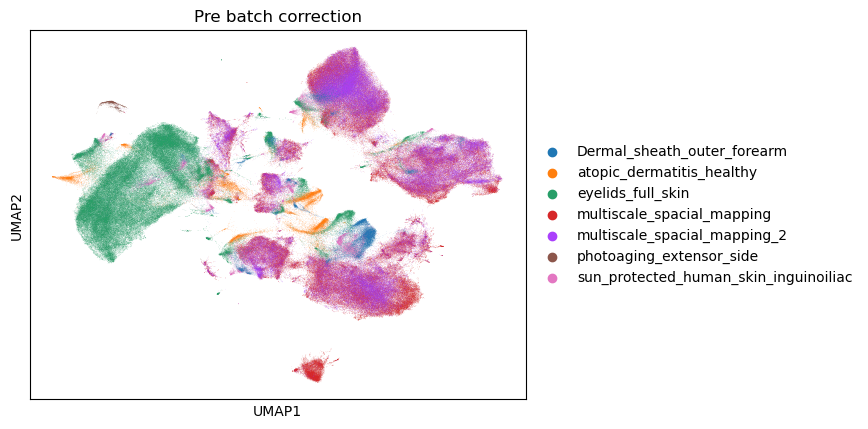

In [39]:
sc.pl.umap(adata_filtered, color='Publication', title = "Pre batch correction")

In [47]:
# sc.pl.umap(adata_filtered, color='KRT10')
cell_type_genes = {
    "Basal Keratinocytes": ["KRT14", "COL17A1", "IGFBP3", "COL7A1"],
    "Spinous Cells": ["LOR", "KRT10", "KRT1"],
    "Granular Cells": ["FLG"],
    "Mitotic Cells": ["TK1", "MKI67"],
    "Hair Follicle Cells": ["SOX9", "KRT6B", "SFRP1"],
    "Melanocytes": ["TYR", "DCT"],
    "Immune Cells": ["PTPRC"],
    "Endothelial Cells": ["CLDN5", "CDH5"],
    "Pericytes": ["PDGFRB", "CSPG4", "RGS5"],
    "Fibroblasts": ["COL1A1", "COL1A2", "PDGFRA", "DCN"],
    "Papillary Fibroblasts": ["PDPN", "MMP1", "LOXL3", "DCN", "APCDD1"],
    "Reticular Fibroblasts": ["COL11A1", "ACAN", "TGM2", "MGP", "ELN", "FGF7"],
    "Fibroblast Activation": ["HES1", "IER2", "ID3", "TSC22D1", "GADD45B", "ID1", "ZFP36"],
    "Keratinocytes": ["KLF6"]
}
for cell_type, gene_list in cell_type_genes.items():
    for gene in gene_list:
        # print(gene)
        sc.settings.set_figure_params(dpi=100, facecolor='white')
        filepath = "/home/jovyan/ifbdata/spatial_cell_id/Kush/Scanpy_analysis/New_analysis/scvi_pre_batch/"
        sc.pl.umap(adata_filtered, color=gene, title=f"{gene}", show=False)
        plt.savefig(os.path.join(filepath, f"{gene}.png"), dpi=300, bbox_inches="tight")
        plt.close()

In [48]:
adata_bbknn = adata_filtered.copy()

In [49]:
adata2 = adata_bbknn.raw.to_adata()

In [51]:
adata2.uns['log1p']['base']=None

In [52]:
sc.pp.highly_variable_genes(adata2, batch_key = 'Publication')

In [53]:
var_select = adata2.var.highly_variable_nbatches > 2
var_genes = var_select.index[var_select]
len(var_genes)

2708

In [55]:
sc.external.pp.bbknn(adata2, batch_key='Publication', n_pcs=30)
sc.tl.umap(adata2, random_state=7)

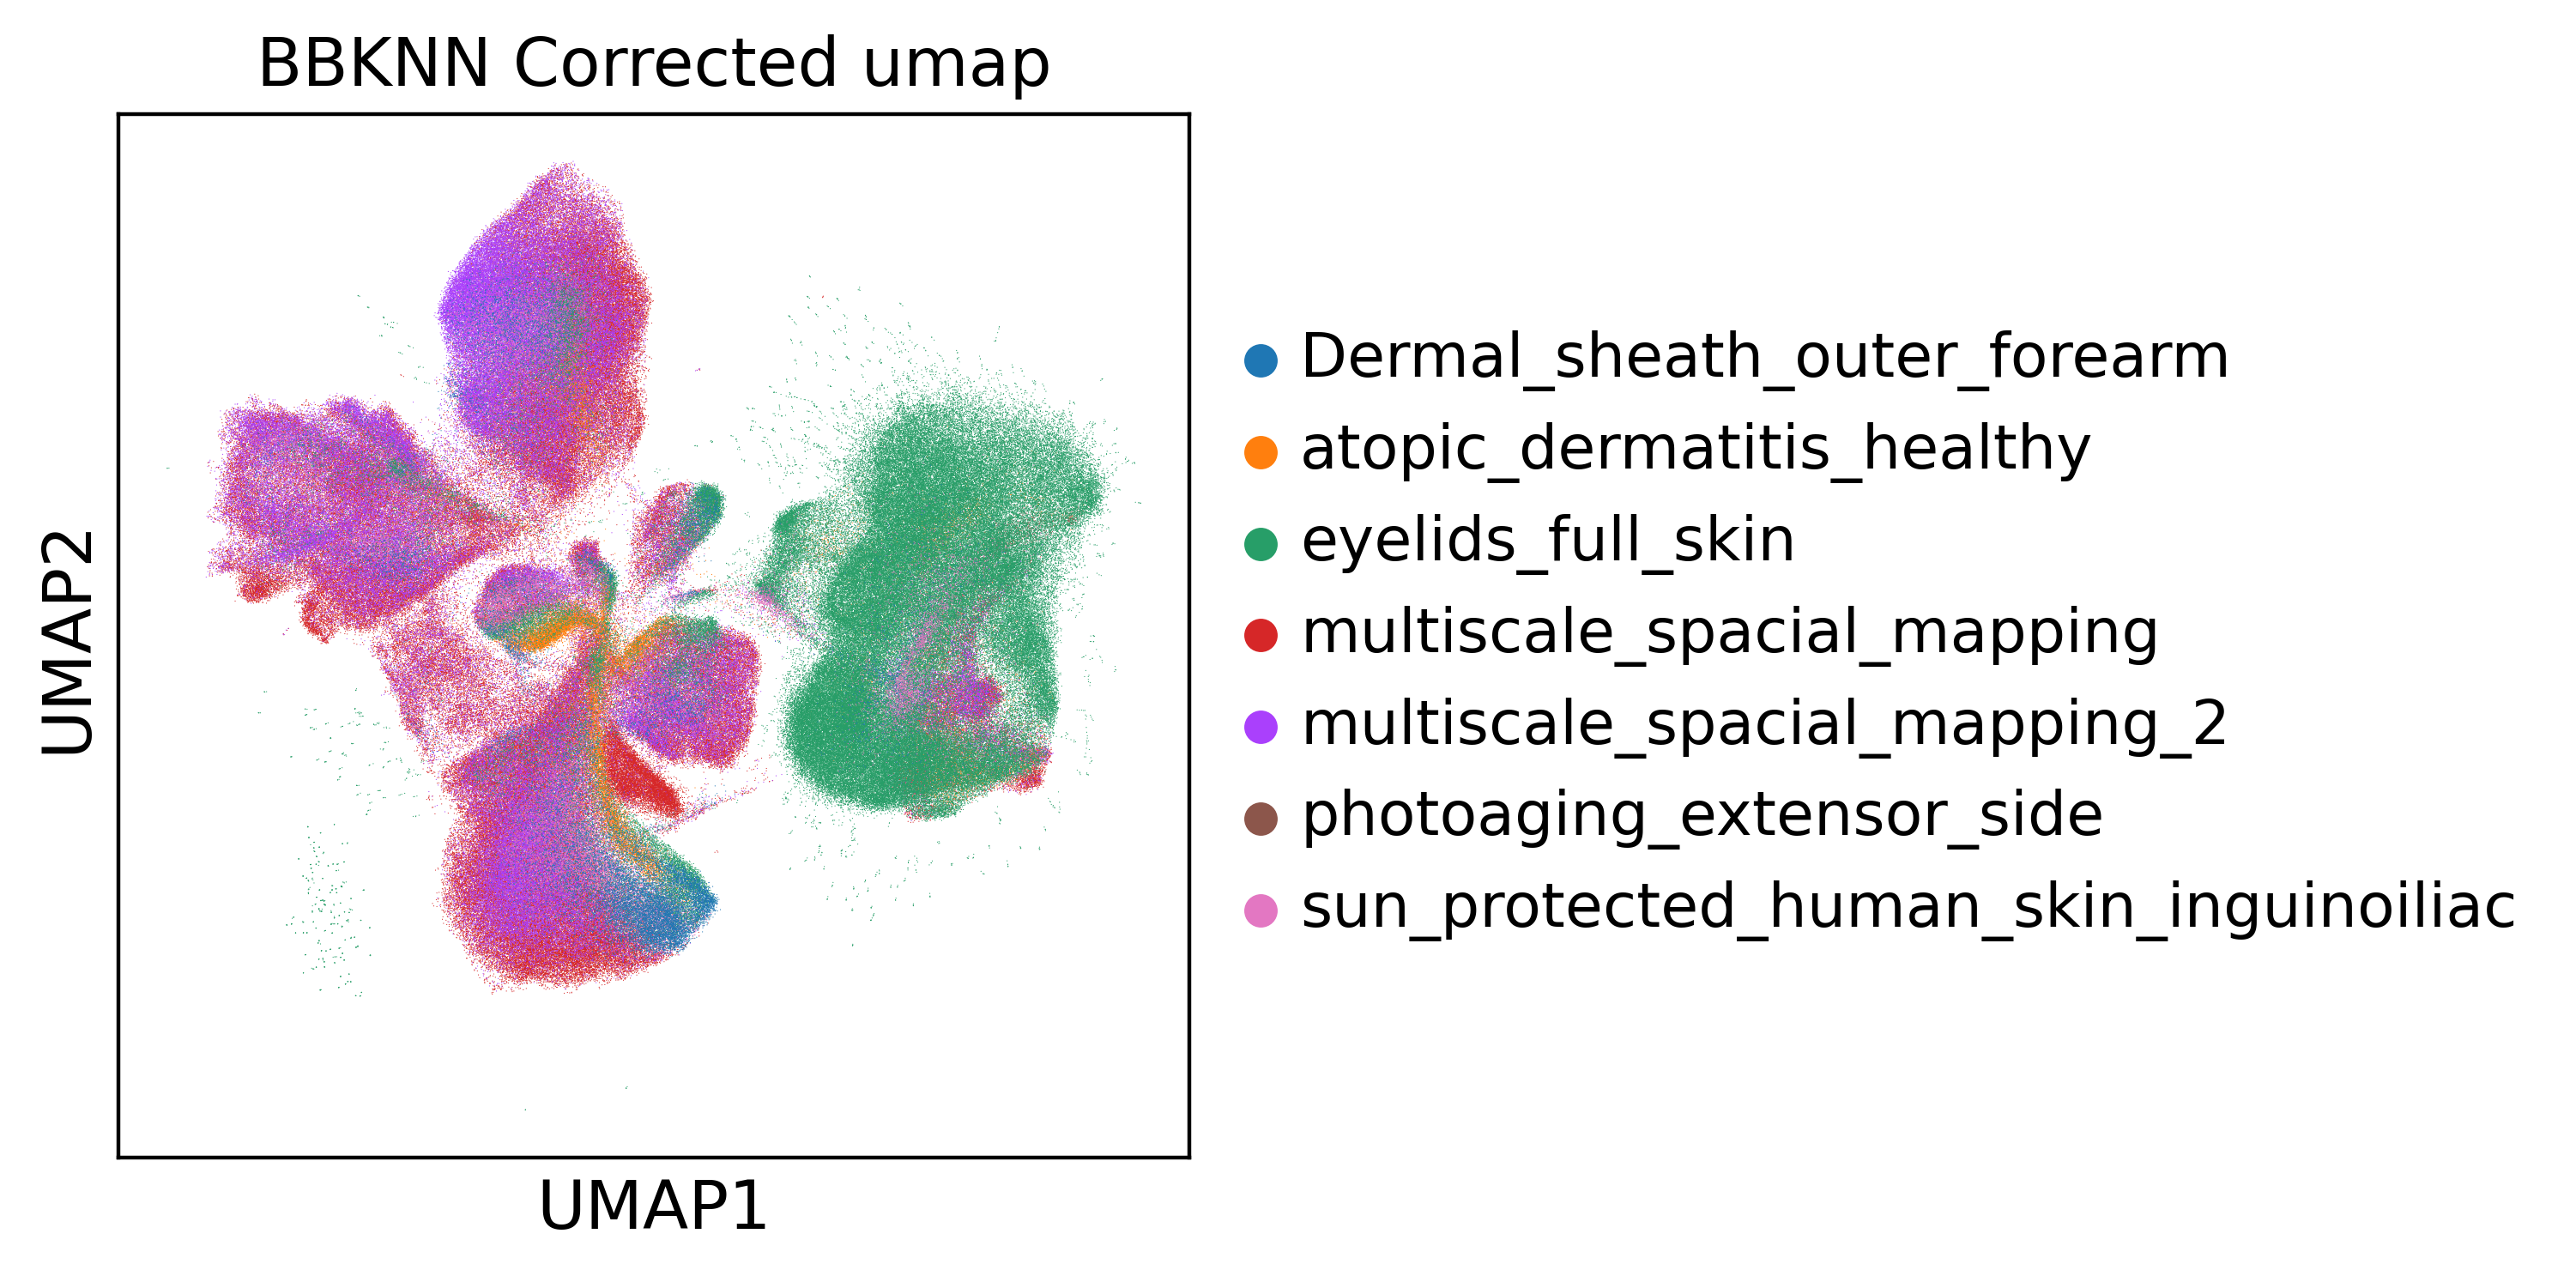

In [56]:
sc.settings.set_figure_params(dpi = 200, facecolor='white')
sc.pl.umap(adata2, color="Publication", title="BBKNN Corrected umap")

In [61]:
# sc.pl.umap(adata2, color='COL7A1')
cell_type_genes = {
    "Basal Keratinocytes": ["KRT14", "COL17A1", "IGFBP3", "COL7A1"],
    "Spinous Cells": ["LOR", "KRT10", "KRT1"],
    "Granular Cells": ["FLG"],
    "Mitotic Cells": ["TK1", "MKI67"],
    "Hair Follicle Cells": ["SOX9", "KRT6B", "SFRP1"],
    "Melanocytes": ["TYR", "DCT"],
    "Immune Cells": ["PTPRC"],
    "Endothelial Cells": ["CLDN5", "CDH5"],
    "Pericytes": ["PDGFRB", "CSPG4", "RGS5"],
    "Fibroblasts": ["COL1A1", "COL1A2", "PDGFRA", "DCN"],
    "Papillary Fibroblasts": ["PDPN", "MMP1", "LOXL3", "DCN", "APCDD1"],
    "Reticular Fibroblasts": ["COL11A1", "ACAN", "TGM2", "MGP", "ELN", "FGF7"],
    "Fibroblast Activation": ["HES1", "IER2", "ID3", "TSC22D1", "GADD45B", "ID1", "ZFP36"],
    "Keratinocytes": ["KLF6"]
}
for cell_type, gene_list in cell_type_genes.items():
    for gene in gene_list:
        # print(gene)
        sc.settings.set_figure_params(dpi=100, facecolor='white')
        filepath = "/home/jovyan/ifbdata/spatial_cell_id/Kush/Scanpy_analysis/New_analysis/scvi_post_batch/"
        sc.pl.umap(adata2, color=gene, title=f"{gene}", show=False)
        plt.savefig(os.path.join(filepath, f"{gene}.png"), dpi=300, bbox_inches="tight")
        plt.close()

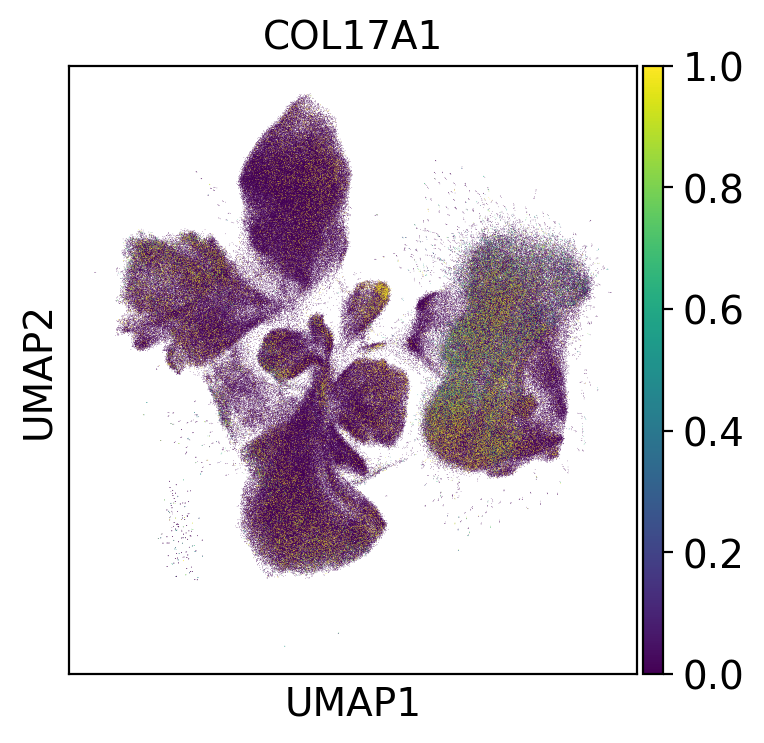

In [77]:
sc.pl.umap(adata2, color='COL17A1', vmax = 1)